In [1]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [2]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [3]:
emb_df = pd.read_csv('../data/embedding/Doc2Vec_embedding_output.csv',index_col=0)

In [4]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.146739,-2.738958,3.672001,4.319488,2.060131,1.106603,2.756807,-1.807586,3.119252,-0.814754,...,2.498754,-1.766720,0.291909,-0.236563,0.366089,-2.615653,2.517367,-2.121267,4.024024,1.430665
1,-3.081997,-4.560731,-0.439482,2.801814,-2.063705,0.320462,2.700044,-1.313459,2.488874,-1.288608,...,3.506879,1.340675,0.644034,0.583566,-1.396967,-2.599615,0.540591,-0.846946,0.476570,1.209218
2,-0.923654,-0.931160,0.270649,0.993372,1.246490,1.068892,0.833382,-0.559276,1.961053,-4.149379,...,5.081479,1.130174,-2.890191,-2.820214,1.395403,-3.846228,-1.152302,-2.224700,1.176310,-0.315757
3,-0.047425,-3.906727,0.635823,0.752494,1.742398,0.973911,0.725889,-0.415176,3.048928,-2.944524,...,3.968297,0.803104,-1.049701,-2.646564,0.847253,-2.600662,-0.752832,0.028893,-0.424166,-1.445955
4,-6.648052,-0.395714,2.429264,2.590817,-0.684888,-1.006098,0.028183,2.124310,1.596855,-2.533973,...,-1.403458,-1.843892,-0.527678,-3.595732,-2.341160,-1.960664,-0.313663,-3.191498,0.681570,-2.437148


In [5]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [6]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [7]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [8]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 'cave_rescue'

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 'duckboat'

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 'helsinki'

In [9]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,cave_rescue
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,cave_rescue
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,cave_rescue
3,chron.com/news/crime/article/young-nubians-rev...,cave_rescue
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,cave_rescue
...,...,...
1920,beforeitsnews.com/opinion-conservative/2018/07...,helsinki
1921,washingtonpost.com/news/powerpost/paloma/the-h...,helsinki
1922,feeds.nydailynews.com/~r/nydnrss/news/national...,helsinki
1923,news.google.com/stories/caaqoqgkijndqkltsurvsm...,helsinki


In [10]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [11]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [12]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((624, 10), (176045, 10))

Sample and include all the labeled article

In [13]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [14]:
sample_emb_df = emb_df.loc[sample_df.index]

In [15]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(sample_emb_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [16]:
admat = nn.kneighbors_graph( mode='connectivity'); admat

<10624x10624 sparse matrix of type '<class 'numpy.float64'>'
	with 106240 stored elements in Compressed Sparse Row format>

In [17]:
G = nx.from_scipy_sparse_matrix(admat)

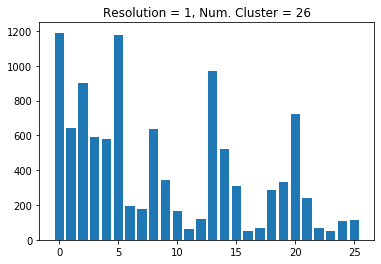

In [18]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [19]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(0, 1190, 298.0)

In [20]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [21]:
pc = clusters# prune_cluster(cluster, 5)

In [22]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

26

In [23]:
len(article_cluster[0].title.tolist())

1190

In [24]:
pc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [25]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
Part of Grand Teton National Park near Yellowstone supervolcano closed after massive fissure opens | Fox News
Trump-Putin summit + initiatives + rent control + Sen. Feinstein
Life after the Bay Area: Fleeing residents feel heartbreak, joy | Miami Herald
US, allies set to evacuate Syrian aid workers from southwest - The San Diego Union-Tribune
North Korea hasn't met its promise to return US war remains - StarTribune.com
FWC seeks input on shore-based shark fishing rules
Medical school class will get free tuition after $3M donation
Amanda Seyfried Made an Amazing Short Film Starring Her Dog, Finn
Manchester aldermen give court-blocked rezoning new life
Schilling: Storm chances start Friday
-------------------------------------------------- text --------------------------------------------------
Part of Grand Teton National Park near Yellowstone supervolcano closed after massive fis

## Top clusters

In [26]:
cluster_sizes = np.array(list(map(len, article_cluster)))

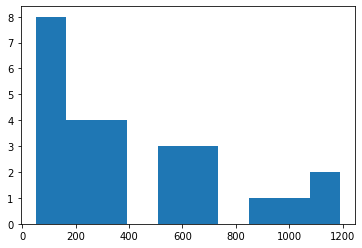

In [27]:
plt.hist(cluster_sizes);

In [28]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1190, 1178,  971,  899,  723,  642,  639,  589,  579,  523,  341,
        333,  308,  288,  241,  196,  179,  166,  117,  113,  106,   70,
         68,   62,   52,   51])

In [29]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
11,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,helsinki
10702,33,washingtonpost.com/news/worldviews/wp/2018/07/...,7/19/2018 2:12:11 PM -04:00,"After being called ‘aggressive’ by Trump, Mont...","After being called ‘aggressive’ by Trump, Mont...",1,en,77,3781,helsinki
10753,33,washingtonpost.com/news/capital-weather-gang/w...,7/19/2018 5:37:12 PM -04:00,"Dozens dead in Japan from record-setting, long...","Dozens dead in Japan from record-setting, long...",1,en,74,2257,helsinki
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
11440,22,nytimes.com/aponline/2018/07/18/science/ap-us-...,7/19/2018 6:02:01 AM -04:00,Study: National Parks Get Fewer Visits When Po...,Study: National Parks Get Fewer Visits When Po...,1,en,61,4051,cave_rescue


In [30]:
print('\n'.join(top_cluster.title.tolist()[:10]))

LA Liberals Stage "Emergency Protest" At Kosher Café Because Owner Supports
After being called ‘aggressive’ by Trump, Montenegro insists it’s a friend to
Dozens dead in Japan from record-setting, long duration extreme heat event
Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Study: National Parks Get Fewer Visits When Pollution Rises -
duck boat capsized in Missouri - Overview
Stocks slide after disappointing earnings, Trump dumps on Fed | Seeking Alpha
Ford recalls 550,000 Escape, Fusion vehicles over rollaway concerns - Roadshow
Vice president touts tax cuts, stumps for Hawley in St. Louis visit | FOX2now.com
Sheriff: 8 dead after Missouri tourist boat accident


In [31]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

/Users/tniyomkarn/via_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
articles = pd.concat(article_cluster)

In [33]:
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()

In [34]:
HTML(assignments.to_html())

## Evaluate

In [35]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby(['label','assignment']).apply(lambda x: x['label'].count()))
cluster_to_prediction

0
label       assignment    
cave_rescue 0           12
            1            9
            2           10
            3           10
            4            7
...                     ..
helsinki    21          10
            22           4
            23           4
            24           2
            25           5

[73 rows x 1 columns]

In [36]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby("assignment").apply(lambda x: x['label'].mode()))
cluster_to_prediction = cluster_to_prediction.reset_index().groupby('assignment').apply(lambda x: x.sample(1)).reset_index(drop = True)[['assignment', 0]]

In [37]:
cluster_to_prediction.columns = ['assignment', 'prediction']
cluster_to_prediction

,assignment,prediction
0,0,helsinki
1,1,helsinki
2,2,helsinki
3,3,helsinki
4,4,helsinki
5,5,helsinki
6,6,helsinki
7,7,helsinki
8,8,helsinki
9,9,helsinki


In [38]:
articles = articles.merge(cluster_to_prediction, on=('assignment'))
articles['label'].fillna('unlabeled', inplace=True)
articles.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment,prediction
0,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,helsinki,0,helsinki
1,33,washingtonpost.com/news/worldviews/wp/2018/07/...,7/19/2018 2:12:11 PM -04:00,"After being called ‘aggressive’ by Trump, Mont...","After being called ‘aggressive’ by Trump, Mont...",1,en,77,3781,helsinki,0,helsinki
2,33,washingtonpost.com/news/capital-weather-gang/w...,7/19/2018 5:37:12 PM -04:00,"Dozens dead in Japan from record-setting, long...","Dozens dead in Japan from record-setting, long...",1,en,74,2257,helsinki,0,helsinki
3,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki,0,helsinki
4,22,nytimes.com/aponline/2018/07/18/science/ap-us-...,7/19/2018 6:02:01 AM -04:00,Study: National Parks Get Fewer Visits When Po...,Study: National Parks Get Fewer Visits When Po...,1,en,61,4051,cave_rescue,0,helsinki


[[ 376    0    0    0]
 [ 108    2    0    0]
 [ 137    1    0    0]
 [9941   59    0    0]]


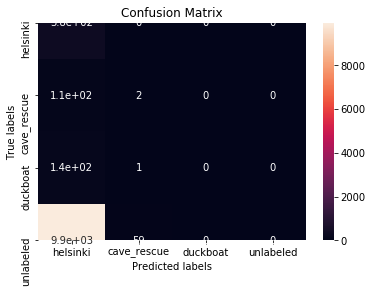

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

labels = articles['label'].unique()
cm = confusion_matrix(list(articles['label']), list(articles['prediction']), labels)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = sns.heatmap(cm, annot=True, ax = ax);
plt.title('Confusion matrix of the classifier')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [40]:
cm_without_unlabeled = cm[:-1, :-1]
acc = np.trace(cm_without_unlabeled)/np.sum(cm_without_unlabeled)
print("Accuracy: ", acc)

Accuracy:  0.6057692307692307


In [41]:
cm_without_unlabeled

array([[376,   0,   0],
       [108,   2,   0],
       [137,   1,   0]])

In [42]:
labeled_articles = articles.dropna(subset=['label'])
concat_labeled_articles = list(labeled_articles[['text','prediction']].groupby(['prediction'])['text'].apply(lambda x: ' '.join(x)))
# df[['name','text','month']].drop_duplicates()

## Tf-idf using 2 groups

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(concat_labeled_articles)

In [44]:
vectors.todense()

matrix([[0.00000000e+00, 8.96718687e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.22814342e-03, 7.73511825e-03, 9.76476540e-06, ...,
         3.25492180e-06, 3.25492180e-06, 3.25492180e-06]])

In [45]:
tfidfs = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())

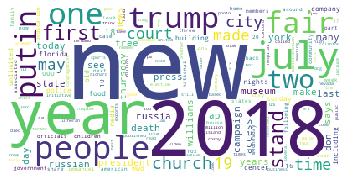

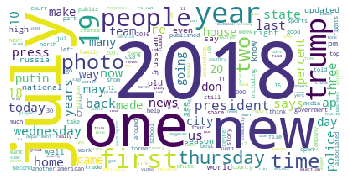

In [46]:
from wordcloud import WordCloud, STOPWORDS

stopwords = STOPWORDS
stopwords.update(["said", "will"])
for i in range(0, len(tfidfs)):
    d = {}
    for k,v in tfidfs.T[i].reset_index().values:
        d[k] = v
    d = {key: d[key] for key in d if key not in stopwords}
            
    wordcloud = WordCloud(background_color = 'white', stopwords=stopwords)
    wc = wordcloud.fit_words(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")

## Averaged tf-idf among each group

In [47]:
def avg_tfidf(clustered_articles):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(clustered_articles)
    return np.mean(vectors, axis = 0), vectorizer

In [48]:
avg_tfidf(labeled_articles[labeled_articles['prediction'] == 'helsinki']['text'])

(matrix([[3.28917167e-03, 5.06573382e-03, 6.84822868e-06, ...,
          8.21101657e-06, 7.41788008e-06, 7.41788008e-06]]),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

In [49]:
averaged_tfidfs = labeled_articles[['text','prediction']].groupby(['prediction'])['text'].agg(avg_tfidf)

In [50]:
averaged_tfidfs[1]

(matrix([[3.28917167e-03, 5.06573382e-03, 6.84822868e-06, ...,
          8.21101657e-06, 7.41788008e-06, 7.41788008e-06]]),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, strip_accents=None,
                 sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                 tokenizer=None, use_idf=True, vocabulary=None))

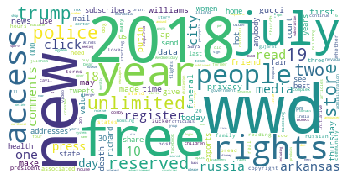

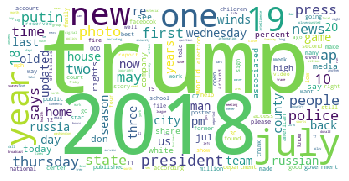

In [51]:
for i in range(0, len(averaged_tfidfs)):
    tf, vec = averaged_tfidfs[i]
    wordcloud = WordCloud(background_color = 'white')
    tfidfs = pd.DataFrame(tf, columns=vec.get_feature_names())
    d = {}
    for k,v in tfidfs.T.reset_index().values:
        d[k] = v
    d = {key: d[key] for key in d if key not in stopwords}
    wc = wordcloud.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")

## Naming clusters

### Assume perfect clustering algorithm

In [53]:
helsinki = articles[articles['label'] == 'helsinki']

In [54]:
helsinki

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment,prediction
0,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,helsinki,0,helsinki
1,33,washingtonpost.com/news/worldviews/wp/2018/07/...,7/19/2018 2:12:11 PM -04:00,"After being called ‘aggressive’ by Trump, Mont...","After being called ‘aggressive’ by Trump, Mont...",1,en,77,3781,helsinki,0,helsinki
2,33,washingtonpost.com/news/capital-weather-gang/w...,7/19/2018 5:37:12 PM -04:00,"Dozens dead in Japan from record-setting, long...","Dozens dead in Japan from record-setting, long...",1,en,74,2257,helsinki,0,helsinki
3,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki,0,helsinki
6,62,seekingalpha.com/news/3371805-stocks-slide-dis...,7/19/2018 5:02:28 PM -04:00,"Stocks slide after disappointing earnings, Tru...","Stocks slide after disappointing earnings, Tru...",1,en,77,1104,helsinki,0,helsinki
...,...,...,...,...,...,...,...,...,...,...,...,...
10511,98,npr.org/2018/07/19/630378093/trump-administrat...,7/19/2018 6:18:13 AM -04:00,Weakens Political Nonprofit Disclosures : NPR,Trump Administration Weakens Political Nonprof...,1,en,45,347,helsinki,25,helsinki
10512,193,denverpost.com/2018/07/19/trumps-white-house-i...,7/19/2018 8:58:23 PM -04:00,U.S. security officials visiting Colorado caug...,President Donald Trump caught two of his top n...,1,en,101,4243,helsinki,25,helsinki
10513,102,slate.com/articles/podcasts/if_then/2018/07/a_...,7/19/2018 5:50:10 AM -04:00,"A top twitter exec on tackling trolls, Congres...",Photo illustration by Slate. Photos by Elisant...,1,en,138,1065,helsinki,25,helsinki
10514,6,yahoo.com/news/undaunted-criticism-trump-looks...,7/19/2018 2:04:29 PM -04:00,Trump rejects Putin offer on interviewing Amer...,Trump rejects Putin offer on interviewing Amer...,1,en,51,6137,helsinki,25,helsinki


In [79]:
import spacy
#get the noun, verb, word entity for each articles
nlp = spacy.load("en_core_web_sm")
noun_phrases_list = []
verb_phrases_list = []
entites_list = []
for text in helsinki['text']:
    doc = nlp(text)
    noun_phrases_list.append([chunk.text for chunk in doc.noun_chunks])
    verb_phrases_list.append([token.lemma_ for token in doc if token.pos_ == "VERB"])
    entites_list.append([entity.text for entity in doc.ents])

In [64]:
'Helsinki' in entites_list

True

In [66]:
len(entites_list)

33681

In [67]:
sum(np.array(entites_list) == 'Helsinki')

176

In [86]:
import re

cleaned_entity_list = [[re.sub('[^0-9a-zA-Z ]+', '', ent).strip() for ent in entites] for entites in entites_list]
cleaned_entity_list = [[ce for ce in cleaned_entities if ce != ''] for cleaned_entities in cleaned_entity_list]

In [118]:
N = len(cleaned_entity_list)

In [92]:
wordSet = set().union(*[set(lis) for lis in cleaned_entity_list])

In [107]:
wordDicts = [dict.fromkeys(wordSet, 0)] * len(cleaned_entity_list)


In [110]:
wordDF = pd.DataFrame(wordDicts)

In [113]:
for idx, art in enumerate(cleaned_entity_list):
    for word in art:
        wordDF.iloc[idx][word]+=1

In [122]:
import math
idf = np.log10(N/np.sum(wordDF))

In [125]:
topic_tfidf = wordDF*idf

In [134]:
# Expect to see 'Helsinki' somewhere on top
top_n = 20
top_n_keywords = np.mean(topic_tfidf).sort_values(ascending=False)[:top_n]
top_n_keywords

the United States    0.159756
Washington           0.159738
Republican           0.159738
Trumps               0.159722
Senate               0.159722
the White House      0.159312
Google               0.158880
2016                 0.157901
Republicans          0.157171
NATO                 0.157139
Democratic           0.156672
AP                   0.155624
two                  0.155624
China                0.155020
Tuesday              0.154707
Helsinki             0.154035
American             0.153746
Monday               0.153702
Wednesday            0.152210
Donald               0.151383
dtype: float64